<a href="https://colab.research.google.com/github/WeizmannML/course2020/blob/master/Tutorial2/Pytorch_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [0]:
#plt.plot( [1,2], [1, 2] )

### Create a 2-feature dataset

In [0]:
# First we create the point that we are going to use for the classifier.
# We create n_points points for four classes of points center at [0,0], 
# [0,2], [2,0] and [2,2] with a deviation from the center that follows a
# Gaussian distribution with a standar deviation of sigma.

n_points = 20000
points = np.zeros((n_points,2))   # x, y
target = np.zeros((n_points,1))   # label
sigma = 0.5
for k in range(n_points):
    # Random selection of one class with 25% of probability per class.
    random = np.random.rand()
    if random<0.25:
        center = np.array([0,0])
        target[k,0] = 0   # This points are labeled 0.
    elif random<0.5:
        center = np.array([2,2])
        target[k,0] = 1   # This points are labeled 1.
    elif random<0.75:
        center = np.array([2,0])
        target[k,0] = 2   # This points are labeled 2.
    else:
        center = np.array([0,2])
        target[k,0] = 3   # This points are labeled 3.
    gaussian01_2d = np.random.randn(1,2)
    points[k,:] = center + sigma*gaussian01_2d

# Now, we write all the points in a file.
points_and_labels = np.concatenate((points,target),axis=1)   # 1st, 2nd, 3nd column --> x,y, label
pd.DataFrame(points_and_labels).to_csv('clas.csv',index=False)

### Creating custom dataset builder

In [0]:
# We read the dataset and create an iterable.
class my_points(data.Dataset):
    def __init__(self, filename):
        pd_data = pd.read_csv(filename).values   # Read data file.
        self.data = pd_data[:,0:2]   # 1st and 2nd columns --> x,y
        self.target = pd_data[:,2:]  # 3rd column --> label
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self, index):   # Function that returns one point and one label.
        return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])

In [0]:
# -- use the custom dataset builder to read the saved file --- #
my_data = my_points('clas.csv')

In [0]:
test_data = my_data.__getitem__(2)

In [7]:
test_data

(tensor([0.8598, 1.1605]), tensor([0.]))

In [8]:
type(test_data)

tuple

In [0]:

batch_size = 200
my_loader = data.DataLoader(my_data,batch_size=batch_size,num_workers=0)

In [0]:
# We build a simple model with the inputs and one output layer.
class my_model(nn.Module):
    def __init__(self,n_in=2,n_hidden=5,n_out=4):
        super(my_model,self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
         
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, self.n_hidden),
            nn.Linear(self.n_hidden ,self.n_hidden),   # Hidden layer.
            nn.Linear(self.n_hidden ,self.n_out)
            )
        self.logprob = nn.LogSoftmax(dim=1)                 # -Log(Softmax probability).
    
    def forward(self,x):
        x = self.linear(x)
        x = self.logprob(x)
        return x

In [0]:
# Now, we create the mode, the loss function or criterium and the optimizer 
# that we are going to use to minimize the loss.

# Model.
model = my_model()

# Negative log likelihood loss.
criterium = nn.NLLLoss()

# Adam optimizer with learning rate 0.1 and L2 regularization with weight 1e-4.
optimizer = torch.optim.Adam(model.parameters(),lr=0.1,weight_decay=1e-4)

In [12]:
loss_array = []
epoch = 0

# Taining.
for k, (data, target) in enumerate(my_loader):
    # Definition of inputs as variables for the net.
    # requires_grad is set False because we do not need to compute the 
    # derivative of the inputs.
    data   = Variable(data,requires_grad=False)
    target = Variable(target.long(),requires_grad=False)
    
    # Set gradient to 0.
    optimizer.zero_grad()
    # Feed forward.
    pred = model(data)
    # Loss calculation.
    loss = criterium(pred,target.view(-1))
    
    loss_array.append(loss.item() )
    # Gradient calculation.
    loss.backward()
    
    
    # Print loss every 10 iterations.
    if k%10==0:
        print('Loss {:.4f} at iter {:d}'.format(loss.item(),k))
        
    # Model weight modification based on the optimizer. 
    optimizer.step()
    
    epoch += 1

Loss 1.4656 at iter 0
Loss 0.1323 at iter 10
Loss 0.1565 at iter 20
Loss 0.1556 at iter 30
Loss 0.2526 at iter 40
Loss 0.1344 at iter 50
Loss 0.1073 at iter 60
Loss 0.1460 at iter 70
Loss 0.0853 at iter 80
Loss 0.1341 at iter 90


In [0]:
loss_array

[1.4183398485183716,
 1.0551203489303589,
 0.8563979864120483,
 0.6573379039764404,
 0.6745700240135193,
 0.4987020790576935,
 0.5096487998962402,
 0.5261693596839905,
 0.4846927225589752,
 0.33853232860565186,
 0.2834238111972809,
 0.22796188294887543,
 0.24100318551063538,
 0.18968617916107178,
 0.2606349587440491,
 0.16507971286773682,
 0.14063751697540283,
 0.13386119902133942,
 0.12387032806873322,
 0.16052421927452087,
 0.12470211833715439,
 0.156971275806427,
 0.23425281047821045,
 0.11944937705993652,
 0.071257084608078,
 0.09811783581972122,
 0.13698934018611908,
 0.1221332848072052,
 0.06319287419319153,
 0.11022818833589554,
 0.2478848695755005,
 0.11797653138637543,
 0.20196819305419922,
 0.17308355867862701,
 0.16037531197071075,
 0.23847422003746033,
 0.17764964699745178,
 0.1549004316329956,
 0.210675448179245,
 0.16311874985694885,
 0.1874532252550125,
 0.1316392570734024,
 0.1622990071773529,
 0.19704896211624146,
 0.21944347023963928,
 0.14088526368141174,
 0.11158945

Reached here


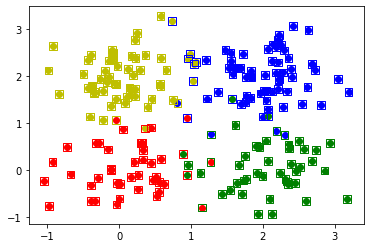

In [13]:
# Now, we plot the results.
# Circles indicate the ground truth and the squares are the predictions.

colors = ['r','b','g','y']
points = data.numpy()

print('Reached here')

# Ground truth.
target = target.numpy()
for k in range(4):
    select = target[:,0]==k
    p = points[select,:]
    plt.scatter(p[:,0],p[:,1],facecolors=colors[k])

# Predictions.
pred = pred.exp().detach()     # exp of the log prob = probability.
_, index = torch.max(pred,1)   # index of the class with maximum probability.
pred = pred.numpy()
index = index.numpy()
for k in range(4):
    select = index==k
    p = points[select,:]
    plt.scatter(p[:,0],p[:,1],s=60,marker='s',edgecolors=colors[k],facecolors='none')

plt.show()